In [17]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from trajectories_clustering import TrajectoryClustering
from trajectory_visualizer_matplot import TrajectoryVisualizerMatplot
import time

In [18]:
import matplotlib
matplotlib.use('Qt5Agg')

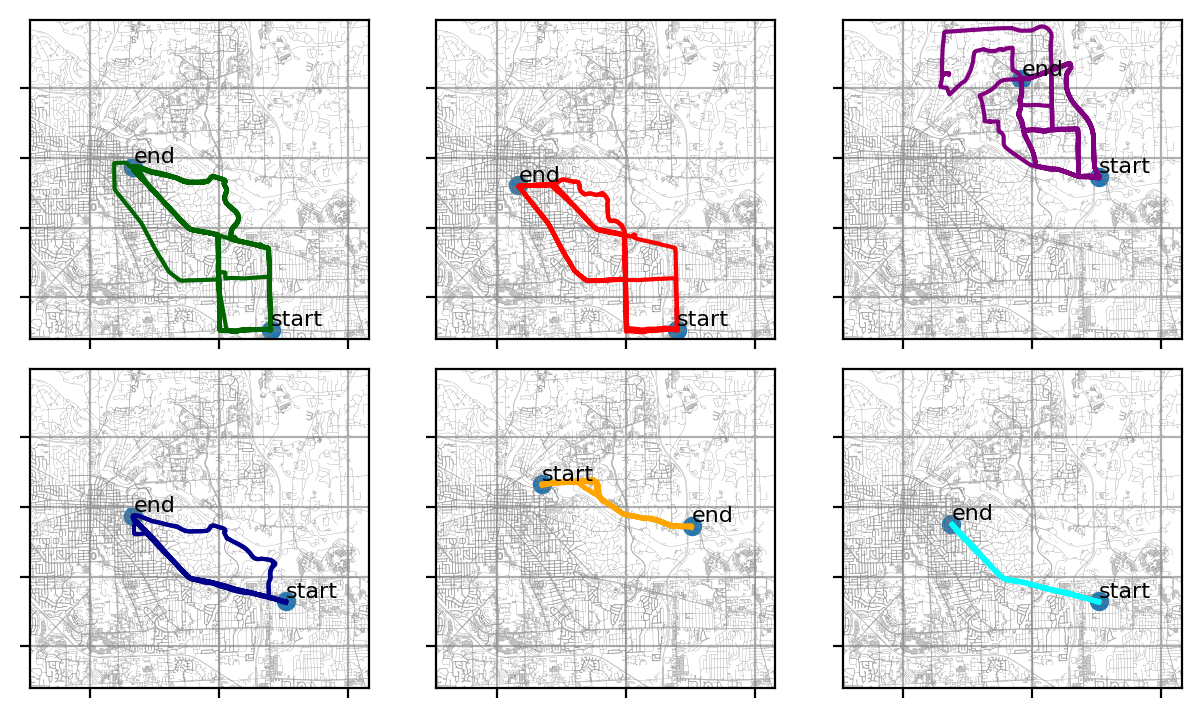

In [39]:
# plot input tragjectories data
clusters = [[1, 184], [1, 173], [11, 22], [29, 184], [144, 11], [29, 185]]
all_trips_logs = []
for cluster_start, cluster_end in clusters:
    g = TrajectoryClustering.get_trajectories(cluster_start, cluster_end)
    all_trips_logs.append(g)
mv = TrajectoryVisualizerMatplot(subplots=(2, 3), dpi=100)
mv.plot_trajectories(all_trips_logs, clusters)
mv.zoom_fit(all_trips_logs)
mv.plot_show()

In [45]:
# load one group of trips, trajectorires with the same start and end location 
cluster_i = 0
cluster_ini, cluster_end = clusters[cluster_i]
trajectories = TrajectoryClustering.get_trajectories(cluster_ini, cluster_end)

In [46]:
# convert trajectories (lat, lon) into (x, y) with unit in meter
trajectories_xy = TrajectoryClustering.convert_lat_lon_to_xy(trajectories)

In [47]:
# reduce trajectories data points by RDP algorithm
trajectories_reduced = [TrajectoryClustering.reduce_polyline_points_by_rdp(p) for p in trajectories_xy]

In [48]:
# data shows there is significant reduction in the number of data points per trajectory
data = [[len(t), len(trajectories_reduced[i])] for i, t in enumerate(trajectories)]
df = pd.DataFrame(data=data, columns=["original data points", "after RDP"])
df.index.name = "traj #"
df.head()

,original data points,after RDP
traj #,,
0,266,21
1,276,36
2,239,34
3,240,32
4,375,33


In [43]:
t0 = time.time()
dist_mat = TrajectoryClustering.calculate_distance_matrix(trajectories_xy)
t1 = time.time()
print("distance matrix without RDP: \tcalcuation time {} seconds".format(t1 - t0))

t0 = time.time()
dist_mat_reduced = TrajectoryClustering.calculate_distance_matrix(trajectories_reduced)
t1 = time.time()
print("distance matrix with RDP: \tcalcuation time {} seconds.".format(t1 - t0))


distance matrix without RDP: 	calcuation time 61.096036195755005 seconds
distance matrix with RDP: 	calcuation time 0.4899632930755615 seconds.


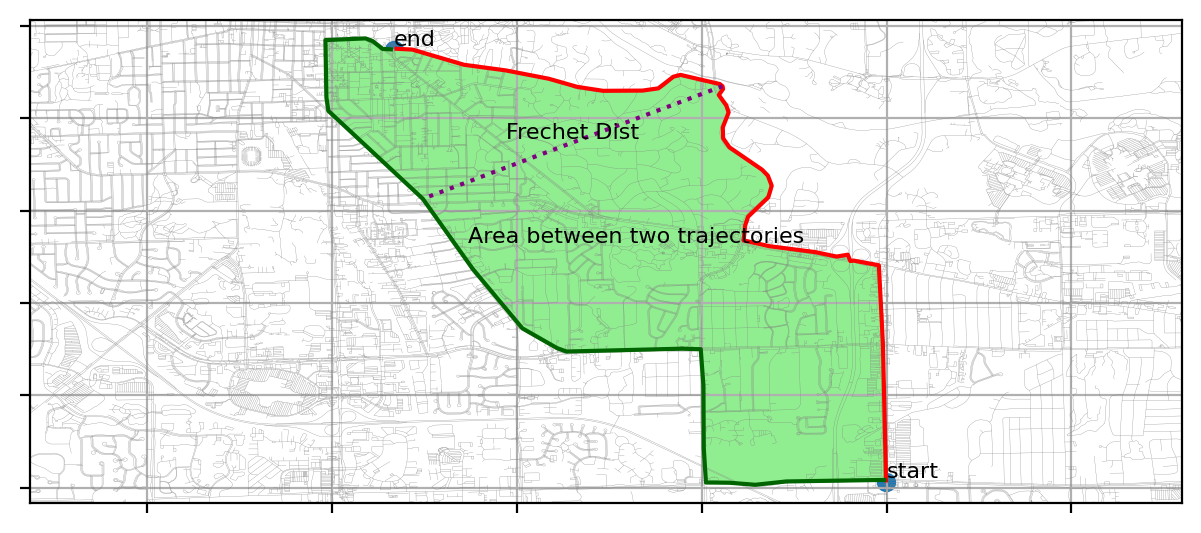

In [49]:
# visualize polyline (trajectory) similarity measures
# Frechet Distance and Area between two polylines
from distance_measures import FrechetDist
from similarity_visualization import PlotSimilarity
from shapely.geometry import Polygon, LineString
from shapely.ops import unary_union, polygonize

trajectories_reduced = [TrajectoryClustering.reduce_polyline_points_by_rdp(p, return_indices=True)
                        for p in trajectories_xy]
points_indices = [t[1] for t in trajectories_reduced]
trajectories_reduced = [t[0] for t in trajectories_reduced]
dist_mat_reduced = TrajectoryClustering.calculate_distance_matrix(trajectories_reduced)
labels = TrajectoryClustering.clustering_by_dbscan(dist_mat_reduced, eps=1000)

c0 = [i for i, l0 in enumerate(labels) if l0 == 1][0]
c1 = [i for i, l1 in enumerate(labels) if l1 == 0][0]
f_d, p_i, q_i = FrechetDist.frechetdist_index(trajectories_reduced[c0], trajectories_reduced[c1])
sel_clusters = [clusters[cluster_i]]

all_trips_logs = [[trajectories[c][points_indices[c], :] for c in [c0, c1]]]
mv = TrajectoryVisualizerMatplot(subplots=(1, 1), dpi=100)
mv.plot_clustered_trajectories(all_trips_logs, sel_clusters, [[c0, c1]])
mv.zoom_fit(all_trips_logs)
PlotSimilarity.plot_area_between(all_trips_logs[0][0], all_trips_logs[0][1], axis=mv.axes[0])
PlotSimilarity.plot_frechet_dist(trajectories_reduced[c0], trajectories_reduced[c1],
                                 all_trips_logs[0][0], all_trips_logs[0][1], axis=mv.axes[0])
mv.plot_show()

In [35]:
# clustering DBSCAN, min_sample is set to 1, as that all trajectories will be clustered into a cluster
def clustering_by_dbscan(cls, distance_matrix, eps=1000):
    """
    :param eps: unit in meter for Frechet distance
    """
    cl = DBSCAN(eps=eps, min_samples=1, metric='precomputed')
    cl.fit(distance_matrix)
    return cl.labels_
labels = TrajectoryClustering.clustering_by_dbscan(dist_mat_reduced, eps=1000)

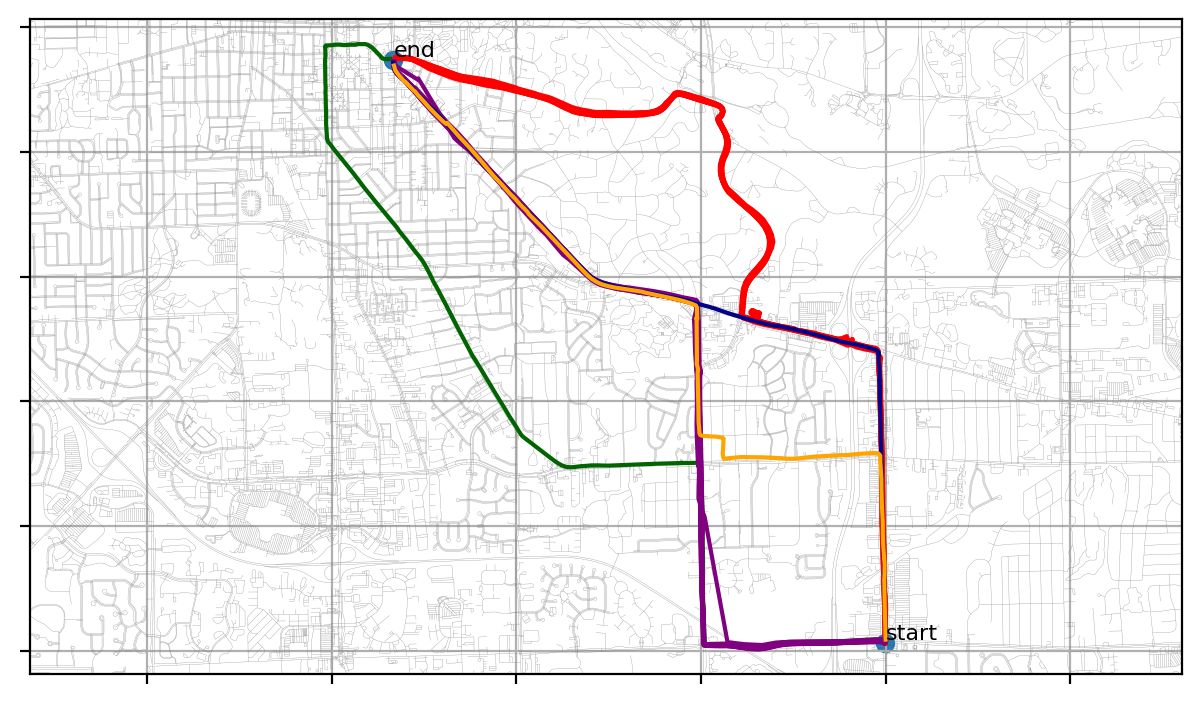

In [50]:
# visualize one group of trajectories
all_trips_logs = [trajectories]
mv = TrajectoryVisualizerMatplot(subplots=(1, 1), dpi=100)
mv.plot_clustered_trajectories(all_trips_logs, clusters, [labels])
mv.zoom_fit(all_trips_logs)
mv.plot_show()

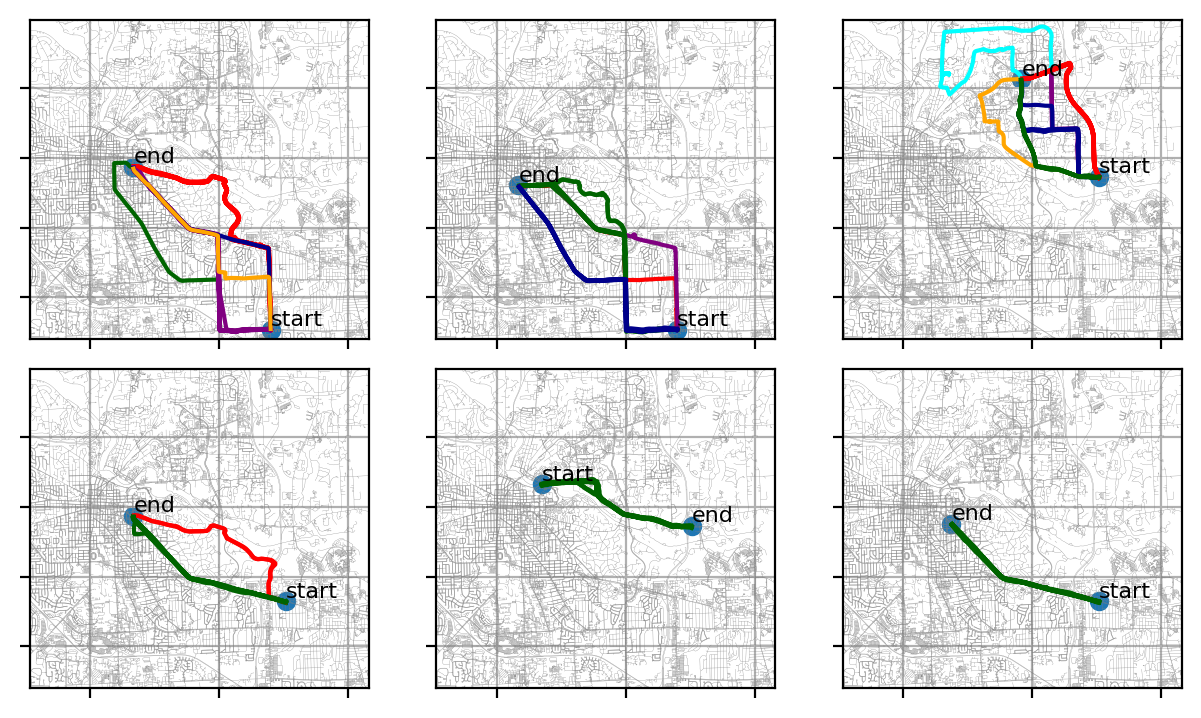

In [51]:
# visualize all six groups of trajectories
all_trips_logs = []
all_labels = []
for cluster_ini, cluster_end in clusters:
    trajectories = TrajectoryClustering.get_trajectories(cluster_ini, cluster_end)
    trajectories_xy = TrajectoryClustering.convert_lat_lon_to_xy(trajectories)

    trajectories_reduced = [TrajectoryClustering.reduce_polyline_points_by_rdp(p, return_indices=False)
                            for p in trajectories_xy]
    dist_mat_reduced = TrajectoryClustering.calculate_distance_matrix(trajectories_reduced)
    labels = TrajectoryClustering.clustering_by_dbscan(dist_mat_reduced, eps=1000)
    all_labels.append(labels)
    all_trips_logs.append(trajectories)
mv = TrajectoryVisualizerMatplot(subplots=(2, 3), dpi=100)
mv.plot_clustered_trajectories(all_trips_logs, clusters, all_labels)
mv.zoom_fit(all_trips_logs)
mv.plot_show()